In [1]:
# Exploratory Data Analysis (EDA)

In [2]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For statistical data visualization
import lightgbm as lgb  # For implementing the LightGBM model
import xgboost as xgb  # For implementing the XGBoost model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For evaluating model performance
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting the data and performing grid search for hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # For feature scaling

# Load the Titanic dataset
train_df = pd.read_csv('Titanic_train.csv')  # Load the training data into a pandas DataFrame
test_df = pd.read_csv('Titanic_test.csv')  # Load the testing data into a pandas DataFrame

# Display the first few rows of the dataset
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Check for missing values in the training DataFrame

# Calculate the number of missing values for each column
missing_values = train_df.isnull().sum()

# Filter the columns to only include those with missing values
columns_with_missing_values = missing_values[missing_values > 0]

columns_with_missing_values


Age         177
Cabin       687
Embarked      2
dtype: int64

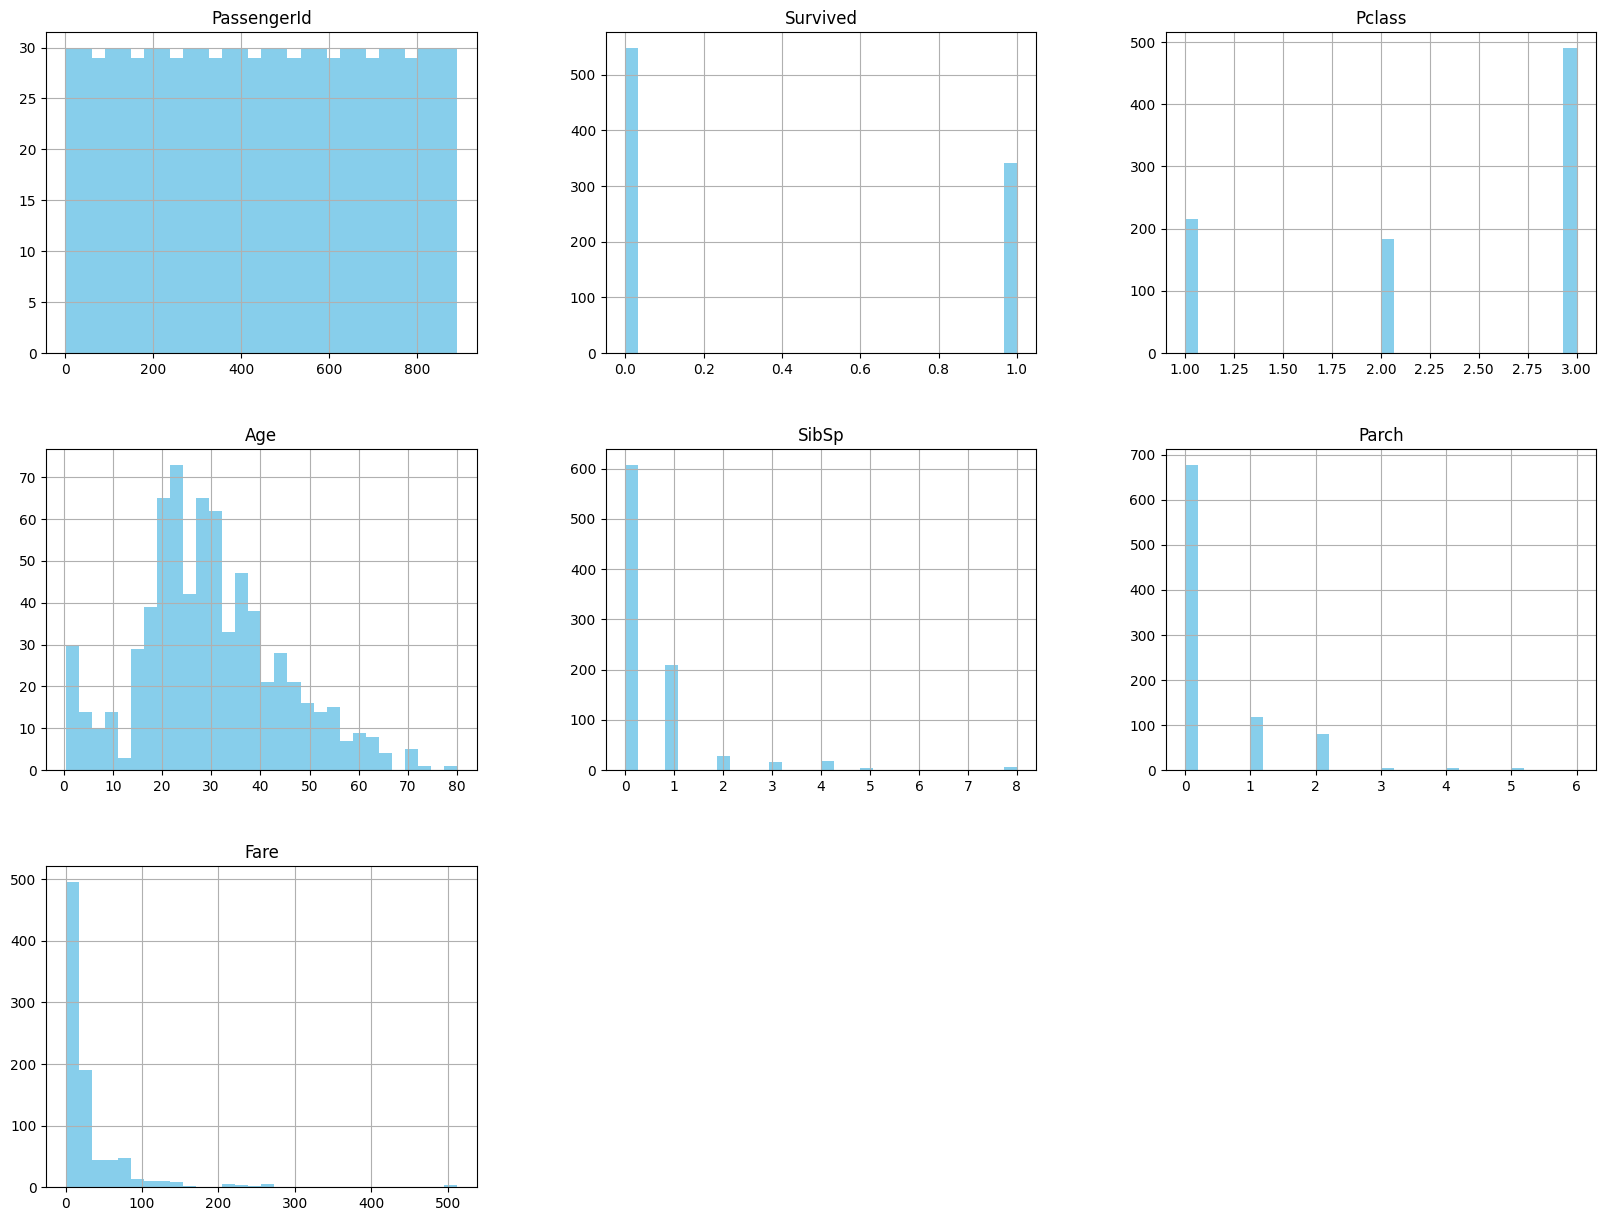

In [4]:
# Explore data distributions using histograms

histogram_color = 'skyblue'

histograms = train_df.hist(bins=30, figsize=(20, 15), color=histogram_color)

plt.show()


<ipython-input-5-93dce6029a31>:3: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(data=train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin']), palette=boxplot_colors)


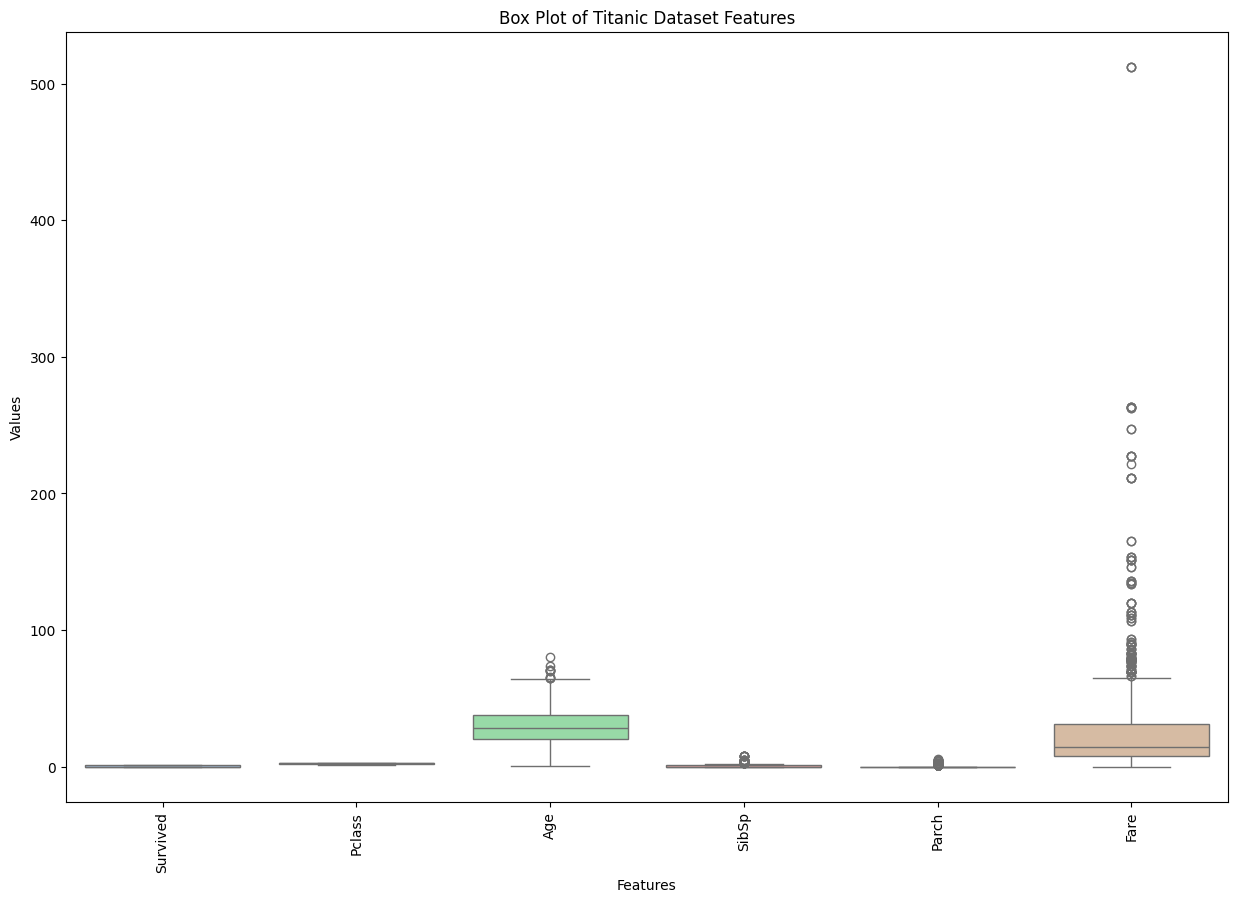

In [5]:
plt.figure(figsize=(15, 10))
boxplot_colors = sns.color_palette("pastel")
sns.boxplot(data=train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin']), palette=boxplot_colors)
plt.xticks(rotation=90)
plt.title('Box Plot of Titanic Dataset Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()


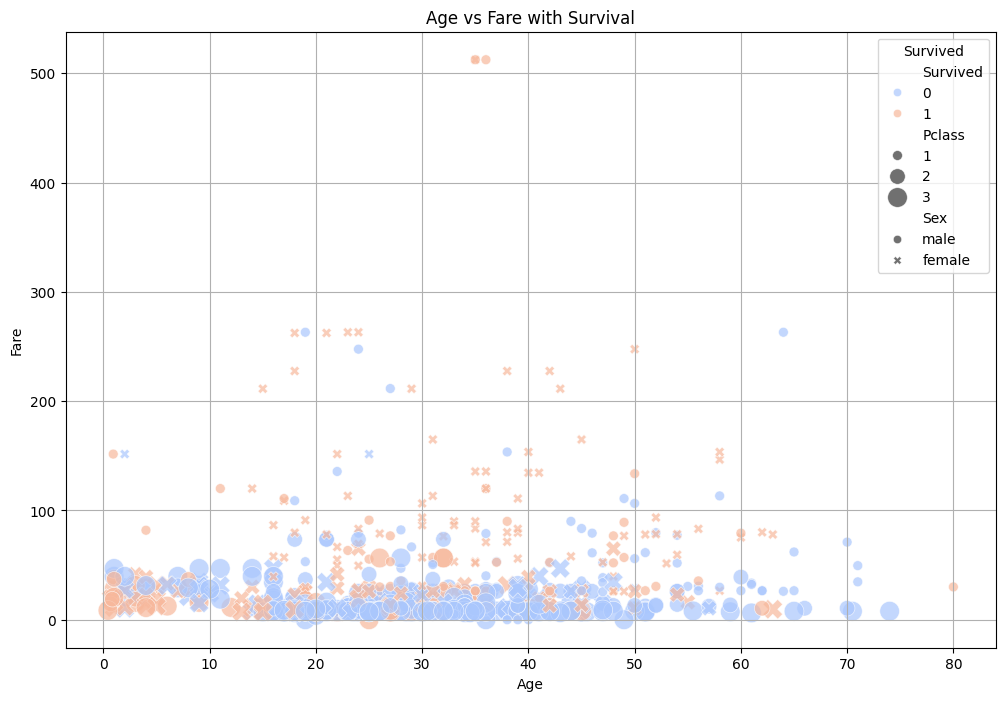

In [6]:
# Visualize relationships between features and survival using scatter plots
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived', style='Sex', palette='coolwarm', size='Pclass', sizes=(50, 200), alpha=0.7, edgecolor='w', linewidth=0.5)
plt.title('Age vs Fare with Survival')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Survived', loc='upper right')
plt.grid(True)
plt.show()


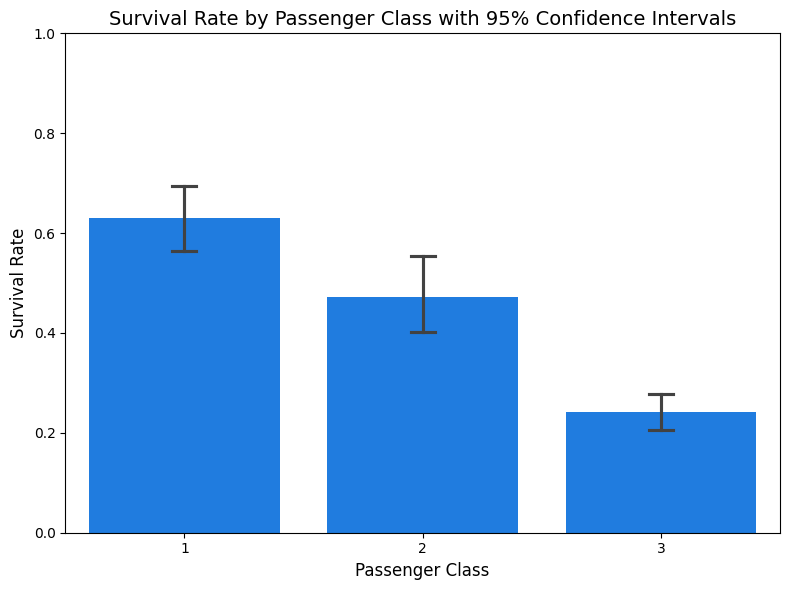

In [7]:
# Visualize relationships between features and survival using bar plots
import seaborn as sns
import matplotlib.pyplot as plt

# Set a vibrant color palette
custom_palette = ["#007bff", "#dc3545"]  # Blue and Red
sns.set_palette(custom_palette)

# Create the bar plot with error bars for confidence intervals
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x='Pclass', y='Survived', errorbar=('ci', 95), capsize=0.1)

# Add labels and a title
plt.xlabel('Passenger Class', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)
plt.title('Survival Rate by Passenger Class with 95% Confidence Intervals', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()



In [8]:
# Impute missing values for 'Age' and 'Embarked'
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Drop 'Cabin' due to a large number of missing values
train_df.drop(columns=['Cabin'], inplace=True)

# Encode categorical variables using one-hot encoding
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)

# Drop non-informative columns
train_df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# Display the first few rows of the preprocessed dataset
train_df.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [9]:
# Split the preprocessed dataset into training and testing sets
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assume train_df is already preprocessed and split into X_train, X_test, y_train, y_test
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'min_child_samples': [20],
    'subsample': [0.8]
}

xgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'min_child_weight': [1],
    'subsample': [0.8]
}

# Perform Grid Search with cross-validation for LightGBM
lgb_grid = GridSearchCV(lgb.LGBMClassifier(), param_grid=lgb_param_grid, cv=5, scoring='accuracy')
lgb_grid.fit(X_train_scaled, y_train)
lgb_best_params = lgb_grid.best_params_
lgb_best_score = lgb_grid.best_score_

# Perform Grid Search with cross-validation for XGBoost
xgb_grid = GridSearchCV(xgb.XGBClassifier(), param_grid=xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid.best_params_
xgb_best_score = xgb_grid.best_score_

lgb_best_params, lgb_best_score, xgb_best_params, xgb_best_score


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

({'learning_rate': 0.01,
  'min_child_samples': 20,
  'n_estimators': 200,
  'num_leaves': 31,
  'subsample': 0.8},
 0.8286220821432089,
 {'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200,
  'subsample': 0.8},
 0.8328769821727567)

In [17]:
# Initialize the models with the best parameters
lgb_best_model = lgb.LGBMClassifier(**lgb_best_params)
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)

# Train the models on the scaled training set
lgb_best_model.fit(X_train_scaled, y_train)
xgb_best_model.fit(X_train_scaled, y_train)

# Define the evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate the models on the scaled testing set
lgb_metrics = evaluate_model(lgb_best_model, X_test_scaled, y_test)
xgb_metrics = evaluate_model(xgb_best_model, X_test_scaled, y_test)

lgb_metrics, xgb_metrics


((0.8100558659217877, 0.8125, 0.7027027027027027, 0.7536231884057971),
 (0.8212290502793296,
  0.7916666666666666,
  0.7702702702702703,
  0.7808219178082192))

In [12]:
# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'LightGBM': lgb_metrics,
    'XGBoost': xgb_metrics
})

metrics_df.set_index('Metric', inplace=True)
metrics_df


,LightGBM,XGBoost
Metric,,
Accuracy,0.810056,0.821229
Precision,0.812500,0.791667
Recall,0.702703,0.770270
F1 Score,0.753623,0.780822


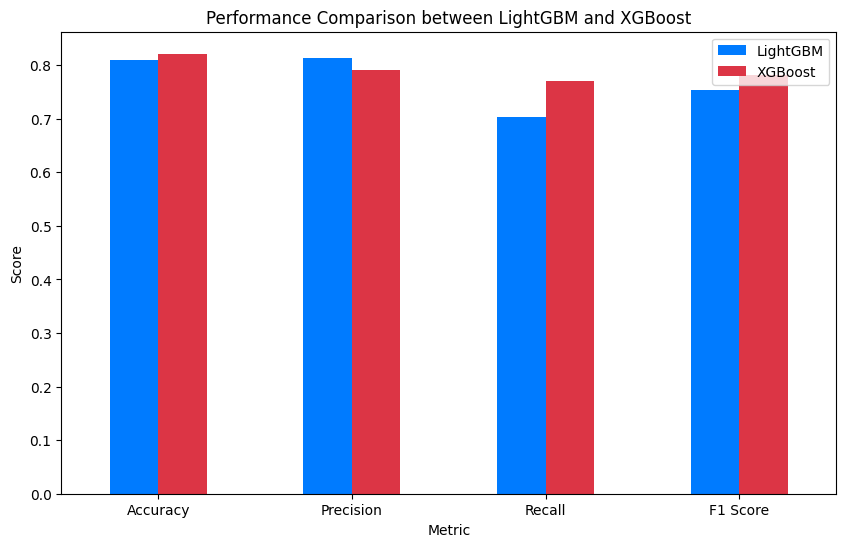

           LightGBM   XGBoost
Metric                       
Accuracy   0.810056  0.821229
Precision  0.812500  0.791667
Recall     0.702703  0.770270
F1 Score   0.753623  0.780822


In [13]:
# Visualize the comparison using bar plots
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison between LightGBM and XGBoost')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Print the metrics for detailed comparison
print(metrics_df)


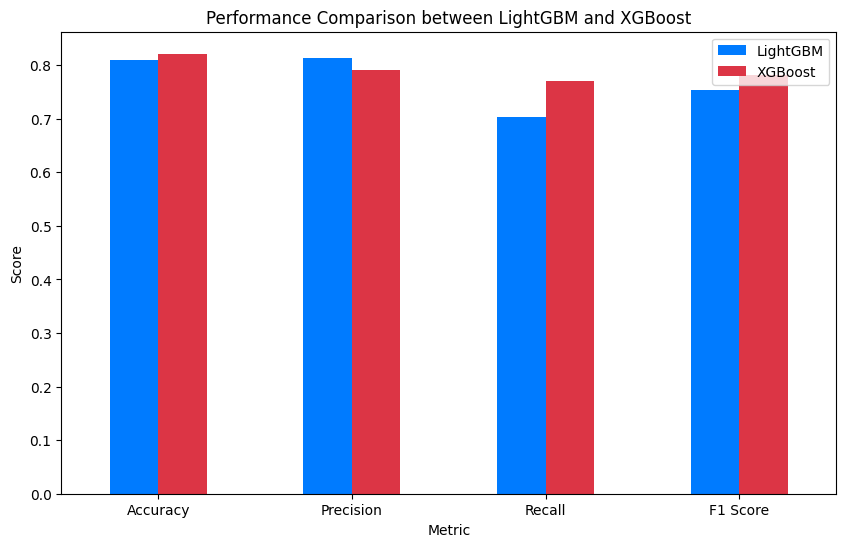

           LightGBM   XGBoost
Metric                       
Accuracy   0.810056  0.821229
Precision  0.812500  0.791667
Recall     0.702703  0.770270
F1 Score   0.753623  0.780822


In [14]:
# Visualize the comparison using bar plots
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison between LightGBM and XGBoost')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Print the metrics for detailed comparison
print(metrics_df)


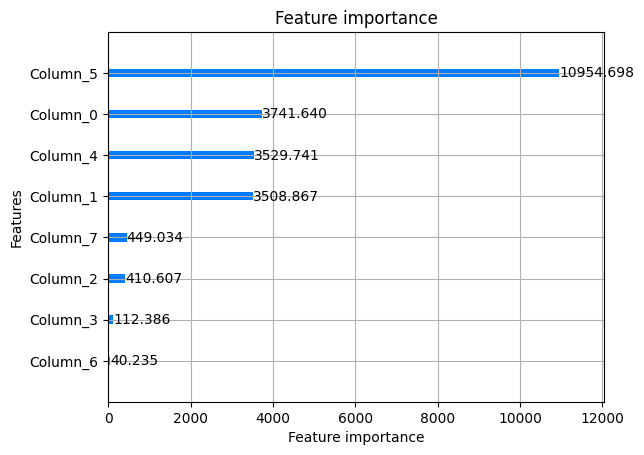

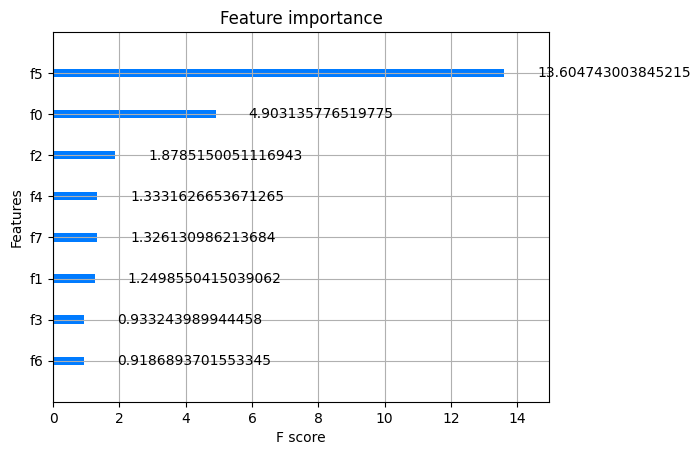

In [15]:
# Check feature importance for LightGBM
lgb.plot_importance(lgb_best_model, max_num_features=20, importance_type='gain')
plt.show()

# Check feature importance for XGBoost
xgb.plot_importance(xgb_best_model, max_num_features=20, importance_type='gain')
plt.show()
